## Imports

In [1]:
import pandas as pd
import numpy as np
import re

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import numpy as np
np.random.seed(2018)

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from transformers import BertTokenizer, BertModel, BertForMaskedLM, PreTrainedModel
from keras.preprocessing.sequence import pad_sequences
import torch

import sklearn
import sklearn.cluster
import sklearn.decomposition
import sklearn.ensemble
import sklearn.manifold
import sklearn.multiclass
import sklearn.tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

## Data Input

In [2]:
# reading iteratively input files
input_df = pd.read_csv('bbc-text.csv')
display(input_df.sample(5))
display(input_df['Category'].value_counts())

,Category,Text
1678,sport,williams says he will never quit defiant matt ...
1034,entertainment,jackson film absolute disaster a pr expert h...
1853,entertainment,ocean s twelve raids box office ocean s twelve...
1078,politics,stalemate in pension strike talks talks aimed ...
466,sport,healey targets england comeback leicester wing...


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: Category, dtype: int64

## Data Preprocessing

Steps:
1. Cutting docs to words
2. Removing stop-words
3. Lemmatization of words


In [3]:
print("avg: ",sum(input_df['Text'].str.len())/len(input_df))
print("min: ",min(input_df['Text'].str.len()))
print("max: ",max(input_df['Text'].str.len()))

avg:  2262.936179775281
min:  501
max:  25483


In [4]:
# average num of chars per topic
print("business:",sum(input_df[input_df['Category'] == 'business']['Text'].str.len())/len(input_df[input_df['Category'] == 'business']))
print("entertainment:",sum(input_df[input_df['Category'] == 'entertainment']['Text'].str.len())/len(input_df[input_df['Category'] == 'entertainment']))
print("sport:",sum(input_df[input_df['Category'] == 'sport']['Text'].str.len())/len(input_df[input_df['Category'] == 'sport']))
print("politics:",sum(input_df[input_df['Category'] == 'politics']['Text'].str.len())/len(input_df[input_df['Category'] == 'politics']))
print("tech:",sum(input_df[input_df['Category'] == 'tech']['Text'].str.len())/len(input_df[input_df['Category'] == 'tech']))

business: 1984.6176470588234
entertainment: 1926.4559585492227
sport: 1894.8825831702543
politics: 2681.822541966427
tech: 2974.216957605985


In [5]:
#factorising categories
# input_df['Category ID'] = pd.factorize(input_df['Category'])[0]
# print(pd.factorize(input_df['Category']))
CatID = []
for i in range(len(input_df)):
    if input_df['Category'][i] == 'business':
        CatID.append(0)
    elif input_df['Category'][i] == 'tech':
        CatID.append(1)
    elif input_df['Category'][i] == 'politics':
        CatID.append(2)
    elif input_df['Category'][i] == 'sport':
        CatID.append(3)
    elif input_df['Category'][i] == 'entertainment':
        CatID.append(4)
input_df['Category ID'] = CatID

In [6]:
# splitting and cleaning text
splitted_texts = [doc.split() for doc in input_df['Text']]
input_df['Splitted Text'] = splitted_texts
stripped = []
for i in range(len(input_df['Splitted Text'])):
    strip = [word.strip(' .,)(""-\'') for word in input_df['Splitted Text'][i]]
    stripped.append(strip)
input_df['Stripped Text'] = stripped
input_df.head(5)

,Category,Text,Category ID,Splitted Text,Stripped Text
0,tech,tv future in the hands of viewers with home th...,1,"[tv, future, in, the, hands, of, viewers, with...","[tv, future, in, the, hands, of, viewers, with..."
1,business,worldcom boss left books alone former worldc...,0,"[worldcom, boss, left, books, alone, former, w...","[worldcom, boss, left, books, alone, former, w..."
2,sport,tigers wary of farrell gamble leicester say ...,3,"[tigers, wary, of, farrell, gamble, leicester,...","[tigers, wary, of, farrell, gamble, leicester,..."
3,sport,yeading face newcastle in fa cup premiership s...,3,"[yeading, face, newcastle, in, fa, cup, premie...","[yeading, face, newcastle, in, fa, cup, premie..."
4,entertainment,ocean s twelve raids box office ocean s twelve...,4,"[ocean, s, twelve, raids, box, office, ocean, ...","[ocean, s, twelve, raids, box, office, ocean, ..."


In [7]:
# removing stop words
filtered = []
stop_words = set(stopwords.words('english'))
for i in range(len(input_df['Stripped Text'])):
    filtered_sentence = [w for w in input_df['Stripped Text'][i] if not w in stop_words]
    filtered.append(filtered_sentence)
input_df['Filtered Text'] = filtered

## Lemmatization

In [8]:
lemmatizer = WordNetLemmatizer() 
#docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
lemmatized = []
for i in range(len(input_df['Filtered Text'])):
    lemat = [lemmatizer.lemmatize(w) for w in input_df['Filtered Text'][i] ]
    lemmatized.append(lemat)
input_df['Lemmatized Text'] = lemmatized
  

# Vector representations

Methods to compare:
- Bert
- Fasttext
- Word2Vec
- LDA

## 1. LDA

In [9]:
dictionary = Dictionary(input_df['Lemmatized Text'])
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

test_data = [dictionary.doc2bow(text) for text in input_df['Lemmatized Text'][1191:]]

In [10]:
len(input_df)

2225

In [11]:
#getting representative train/test split

test = input_df[input_df['Category ID']==0][:50][['Category ID','Lemmatized Text']].copy()
test = test.append(input_df[input_df['Category ID']==1][:50][[ 'Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==2][:50][[ 'Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==3][:50][[ 'Category ID','Lemmatized Text']].copy())
test = test.append(input_df[input_df['Category ID']==4][:50][[ 'Category ID','Lemmatized Text']].copy())
test = test.reset_index(drop=True)

train = input_df[input_df['Category ID']==0][51:][[ 'Category ID','Lemmatized Text']].copy()
train = train.append(input_df[input_df['Category ID']==1][51:][[ 'Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==2][51:][[ 'Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==3][51:][[ 'Category ID','Lemmatized Text']].copy())
train = train.append(input_df[input_df['Category ID']==4][51:][[ 'Category ID','Lemmatized Text']].copy())
train = train.reset_index(drop=True)

In [12]:





# corpus = [dictionary.doc2bow(text) for text in train['Lemmatized Text']]
# # Make a index to word dictionary.
# temp = dictionary[0]  # This is only to "load" the dictionary.
# id2word = dictionary.id2token

# # Set training parameters.
# num_topics = 5
# chunksize = 2000

# eval_every = None  # Don't evaluate model perplexity, takes too much time.



In [13]:
# import logging
# logging.basicConfig( level=logging.INFO)
# Scores = []
# passes = 20
# iterations = 300
# for i in range(1):
    
#     model = LdaModel(
#         corpus=corpus,
#         id2word=id2word,
#         chunksize=chunksize,
#         alpha='auto',
#         eta='auto',
#         iterations=iterations,
#         num_topics=num_topics,
#         passes=passes,
#         eval_every=1
#     )

#     # Compute Coherence Score
#     coherence_model_lda = CoherenceModel(model=model, texts=input_df['Lemmatized Text'], dictionary=dictionary, coherence='u_mass')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)


0 -biz

1- tech

2- polit

3 - sport

4 - enterta

In [14]:
#model.print_topics()

In [15]:
modelLDA = LdaModel.load("LdaModel.model")

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\smart_open\smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [16]:
# Testing accuracy
test_corpus = [dictionary.doc2bow(text) for text in test['Lemmatized Text']]
top_topic = []
for i in range(len(test)):
    lda = modelLDA.get_document_topics(test_corpus[i])
    topic_probab = [lis[1] for lis in lda]
    top_topic.append(lda[topic_probab.index(max(topic_probab))][0])
test['LDA Topic'] = top_topic
LDA_toCat = []
for i in range(len(test)):
    if test['LDA Topic'][i] == 0:
        LDA_toCat.append(0)
    elif test['LDA Topic'][i] == 1:
        LDA_toCat.append(1)
    elif test['LDA Topic'][i] == 2:
        LDA_toCat.append(2)
    elif test['LDA Topic'][i] == 3:
        LDA_toCat.append(4)
    elif test['LDA Topic'][i] == 4:
        LDA_toCat.append(3)
test['LDA to Cat ID'] = LDA_toCat
acc = (len(test[test['Category ID'] ==test['LDA to Cat ID']])/len(test))*100
print("Accuracy: ",acc," %")

Accuracy:  95.19999999999999  %


In [17]:
#model.save("LdaModel.model")

In [18]:
# import matplotlib.pyplot as plt
# mdiff, annotation = model.diff(model, distance='jaccard', num_words=50)
# fig, ax = plt.subplots(figsize=(18, 14))
# data = ax.imshow(mdiff, cmap='RdBu_r', origin='lower')
# print('Topics: ', mdiff)
# plt.title("Topic difference (one model) [jaccard distance]")
# plt.colorbar(data)
# plt.savefig('LDA_topic_diff.png')

NameError: name 'model' is not defined

## 2. Doc2Vec

In [19]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_df['Lemmatized Text'])]
modelDoc2Vec = Doc2Vec(documents, vector_size=200, window=3, min_count=1, workers=4)

#saving the embeddings
input_df['vector'] = [modelDoc2Vec.docvecs[i] for i in range(len(input_df))]
#creating dataframe with the embeddings
a = np.zeros(shape=(len(input_df),100))
scatter_vector = pd.DataFrame(a)
for i in range(len(input_df)):
    for j in range(200):
        scatter_vector.at[i,j] = input_df['vector'][i][j]

In [ ]:

#input_df = pd.concat([input_df,scatter_vector],axis=1)
#input_df.head(3)

## 3. BERT

In [ ]:
# import logging
# logging.basicConfig(level=logging.INFO)

# # Load pre-trained model tokenizer (vocabulary)
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# MAX_LEN = 128
# # Tokenize input
# tokenized_texts = [tokenizer.encode(sent, add_special_tokens=True) for sent in input_df['Lemmatized Text']]
# # Padding input tokens
# input_ids = pad_sequences(tokenized_texts, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")




# attention_masks = []
# # Create a mask of 1s for each token followed by 0s for padding
# for seq in input_ids:
#   seq_mask = [float(i>0) for i in seq]
#   attention_masks.append(seq_mask)

# segments_tensors = torch.tensor(np.array(input_ids)).to(torch.int64)


# modelBert = BertModel.from_pretrained('bert-base-multilingual-cased')
# modelBert.eval()

# with torch.no_grad():
#     outputs = modelBert(segments_tensors)

# 4. FastText

In [31]:
from gensim.models import FastText
modelFastText = FastText(size=100, window=3, min_count=1, sentences=input_df['Lemmatized Text'], iter=10)
# saving vector rep for each word in an article
FastTextEmbeddings = []
for i in range(len(input_df)):
    FastTextEmbeddings.append( [modelFastText[word] for word in input_df['Lemmatized Text'][i]])
#input_df['FastTextVectors'] = FastTextEmbeddings

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [38]:
len(FastTextEmbeddings[0][0])
HorizontalEmbeddings = []
# making the embeddings horizontal
for i in range(len(input_df)):
    

100

# Classifiers

In [ ]:
#BERT
# output_avg = np.mean(outputs[0].numpy(),1)
# X = output_avg
# y = input_df['Category ID']

In [20]:
#Doc2Vec
y = input_df['Category ID']
X = scatter_vector

In [32]:
#FastText
X = FastTextEmbeddings

In [33]:
clf = MLPClassifier(hidden_layer_sizes=(100), random_state=1,
                            max_iter=40)
scores = cross_val_score(clf, X, y, cv=2)
scores.mean()

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Expected 2D array, got 1D array instead:
array=[list([array([ 0.09598258, -0.19350712, -0.1669425 , -0.3019876 ,  0.53934014,
       -0.23439388, -0.1563684 , -0.35282013,  0.2804822 ,  0.59651154,
       -0.49605477,  0.1483964 , -0.03263216, -0.26314133, -0.37544218,
        0.46650818, -0.04354426,  0.07966089, -0.12284672, -0.23707387,
        0.8518065 , -0.42016143,  0.44886038, -0.5757924 , -0.4336403 ,
        0.2224491 , -0.41971195,  0.3413804 , -0.37571323, -0.57758063,
        0.7518213 ,  0.14339752, -0.23280129,  0.17318921, -0.40848854,
       -0.1283194 ,  0.25794944,  0.05748209,  0.4362233 ,  0.06993494,
       -0.4345596 , -0.03392397,  0.43716982,  0.05399679, -0.2670029 ,
        0.21370728,  0.147024

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



nan

In [23]:
clf = MLPClassifier(hidden_layer_sizes=(1200), random_state=1,
                            max_iter=1000)
Scores.append([i*50,cross_val_score(clf, X, y, cv=2)])

In [21]:
# loop for graph
Scores =[]
for i in range(20):
    clf = MLPClassifier(hidden_layer_sizes=(1200), random_state=1,
                            max_iter=i*50)
    Scores.append([i*50,cross_val_score(clf, X, y, cv=2)])
    

C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: max_iter must be > 0, got 0.

  FitFailedWarning)
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\JakubowskiL\AppData\Local\Continuum\anaconda3\envs\bert\lib\site-packages\sklearn\neur

In [24]:
Scores

[[0, array([nan, nan])],
 [50, array([0.88319856, 0.88309353])],
 [100, array([0.92183288, 0.89748201])],
 [150, array([0.92542677, 0.90467626])],
 [200, array([0.92991914, 0.90827338])],
 [250, array([0.9245283 , 0.90827338])],
 [300, array([0.9245283 , 0.90827338])],
 [350, array([0.9245283 , 0.90827338])],
 [400, array([0.9245283 , 0.90827338])],
 [450, array([0.9245283 , 0.90827338])],
 [500, array([0.9245283 , 0.90827338])],
 [550, array([0.9245283 , 0.90827338])],
 [600, array([0.9245283 , 0.90827338])],
 [650, array([0.9245283 , 0.90827338])],
 [700, array([0.9245283 , 0.90827338])],
 [750, array([0.9245283 , 0.90827338])],
 [800, array([0.9245283 , 0.90827338])],
 [850, array([0.9245283 , 0.90827338])],
 [900, array([0.9245283 , 0.90827338])],
 [950, array([0.9245283 , 0.90827338])],
 [950, array([0.9245283 , 0.90827338])]]

In [30]:
AverageScores

[0.8831460438118508,
 0.909657449242762,
 0.915051516738092,
 0.9190962593806357,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782,
 0.9164008415908782]

In [25]:
AverageScores = [item[1].mean() for item in Scores[1:]]
Labels = [item[0] for item in Scores[1:]]

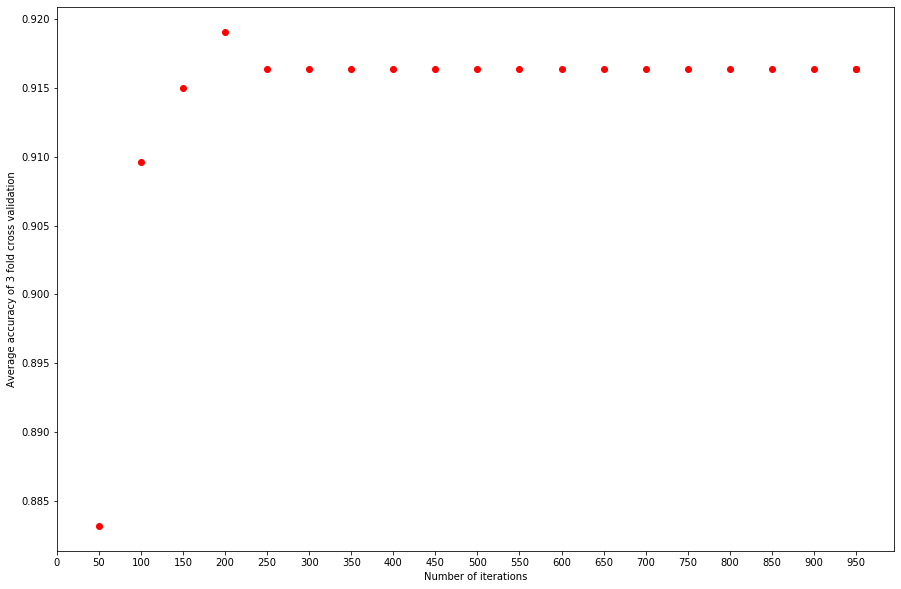

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(Labels,AverageScores,'ro')
plt.xticks(np.arange(0, 1000, step=50))
plt.ylabel('Average accuracy of 3 fold cross validation')
plt.xlabel('Number of iterations')
plt.savefig('Doc2VecIterations.png')
plt.show()


In [ ]:
clf = svm.LinearSVC()
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

In [ ]:
clf = GradientBoostingClassifier(n_estimators=1000, max_leaf_nodes=4, max_depth= None, random_state= 2,
                   min_samples_split= 5)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()